## Assignment 3

Katariina Perkonoja | 514629

### Exercise 1

#### Open ship_data.txt. Check, how many different ship types there are, and how many ships are associated with each ship type.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("shipdata.txt", header = 0, sep = None, engine='python') # importing the data
 # Types and corresponding frequencies of the ship typesdata['Ship type'].value_counts()

#### Plot a scatter plot using ship length and gross tonnage, using a different color for each ship type. Are there any evident outliers? If so, delete the outliers (or alternatively you can try to find the correct value from marinetraffic.com). Do you need to use some transformation? If so, make the transformation.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

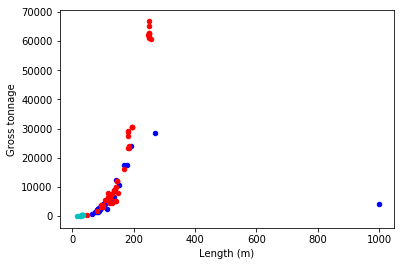

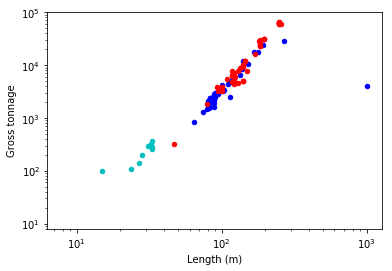

In [4]:
ax1 = data[data['Ship type'] == 'Cargo'].plot(kind='scatter', y='Gross tonnage', x='Length (m)', color='b') 
ax2 = data[data['Ship type'] == 'Tanker'].plot(kind='scatter', y='Gross tonnage', x='Length (m)', color='r', ax = ax1)
ax3 = data[data['Ship type'] == 'Tug'].plot(kind='scatter', y='Gross tonnage', x='Length (m)', color='c', ax = ax1)

# Same plot but using log scale

ax4 = data[data['Ship type'] == 'Cargo'].plot(kind='scatter', y='Gross tonnage', x='Length (m)', color='b') 
ax5 = data[data['Ship type'] == 'Tanker'].plot(kind='scatter', y='Gross tonnage', x='Length (m)', color='r', ax = ax4)
ax6 = data[data['Ship type'] == 'Tug'].plot(kind='scatter', y='Gross tonnage', x='Length (m)', color='c', ax = ax4)
ax4.set_yscale('log')
ax4.set_xscale('log')

plt.show()

Seems that there's one evident outlier for the ship type Cargo so we'll remove it. The relationship seems to be rather exponential, for better understanging log scaled scatter plot should look like linear which it does.

In [5]:
data = data.drop(data['Length (m)'].idxmax(), axis = 0) # dropping out the outlier

#### Destination harbor is a categorical variable. Convert it as numerical. You can use get_dummies from pandas to implement onehot coding for categorical features.


In [6]:
data = pd.get_dummies(data, columns=['Destination'])

#### The numerical variables have quite different ranges so it is good to make a Z-score standardization. Perform it for speed, length, breadth and gross tonnage

In [7]:
from sklearn.preprocessing import StandardScaler

dataz = data.copy() # creating a new dataframe in which the numerical variables are standardized
dataz.iloc[:,[1,4,5,6]] = StandardScaler().fit_transform(dataz.iloc[:,[1,4,5,6]])

### Exercise 2

#### Predict the ship type with the speed, destination, length, breadth and gross tonnage data using kNN classifier with k=3. Find an estimation for the classification accuracy using random training and test sets. Divide the data randomly into training (70 %) and test sets (30 %). Should you use stratification? Why?

Stratification is used because the ship type Tug is underrepresented and some clusterig can be seen in the scatted plot.


#### Repeat the calculation, say, 1000 times, and for each repetition, calculate the classification accuracy, i.e. how many times the classifier predicts the ship type correctly divided by the number of the ships in the test data. Plot the repeated classification accuracy values. Comment your result.

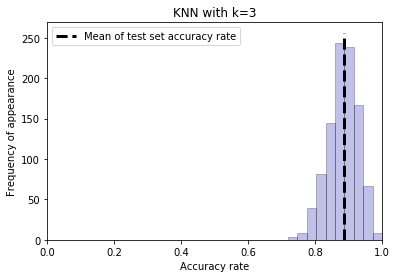

In [8]:
columns = [1] + list(range(4,len(dataz.columns)))

y_set = dataz['Ship type']
X_set = dataz.iloc[:,columns]

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracy = []
np.random.seed(1234)
for i in range(1000):
    # splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.3, stratify = y_set)
    # setting the number of neighbors
    knn = KNeighborsClassifier(n_neighbors=3)
    # fitting the model
    knn.fit(X_test,y_test)
    # calculating predictions using test set
    p = knn.predict(X_test)
    # calculating and storing the accuracy rates
    accur = accuracy_score(p, y_test)
    accuracy.append(accur)
axes = plt.gca()
# plotting the accuracy rates
plt.hist(accuracy, edgecolor="black", facecolor='#0504aa', alpha=0.25)
ylim = axes.get_ylim()
# adding the mean of accuracy rate to the plot
plt.plot(2*[np.mean(accuracy)], ylim, '--k', linewidth=3, label='Mean of test set accuracy rate')
plt.title("KNN with k=3")
plt.legend()
plt.xlim((0,1))
plt.xlabel("Accuracy rate")
plt.ylabel("Frequency of appearance")
plt.show()

In [9]:
np.mean(accuracy), np.min(accuracy), np.max(accuracy)

(0.88521875, 0.71875, 1.0)

It seems that the mean of test set accuracy rate is near 0.9 and the range is [0.72,1] which is pretty decent.

### Exercise 3

#### Predict the ship type with the speed, destination, length, breadth and gross tonnage data using kNN classifier with k=3. Find an estimation of the classification accuracy using leave-one-out. Find the optimal value for k.

#### Divide the data into training and test sets using leave-one-out, i.e. use each ship once as the test data and the remaining ships as the training data, and predict the ship type of the test data using the training data using kNN classifier with k=3. You will get n (=the number of ships in the data) predictions for the ship type. Calculate the classification accuracy, i.e. the how many times the ship type was predicted correctly divided by n. Compare the result with the one you got in task 2. Which method is a better evaluation of the performance of the classifier with this data set? 

In [10]:
from sklearn.model_selection import LeaveOneOut

np.random.seed(1234)

loo = LeaveOneOut()
p = []

for train, test in loo.split(X_set):
    X_train, X_test = X_set.iloc[train], X_set.iloc[test]
    y_train, y_test = y_set.iloc[train], y_set.iloc[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train,y_train)
    p.append(knn.predict(X_test)[0])
    
accur = accuracy_score(p, y_set)

accur

0.8301886792452831

The accuracy for LOOCV (k=3) is 0.83 which is less than the mean value of accuracy in the exercise 2. According to this the method used in exercise 2 seems better.

#### Repeat the calculation in task 3 with values k=1…20. What is the best classification accuracy achieved? 

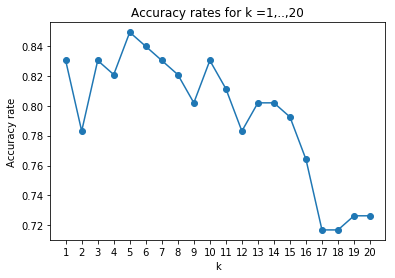

0.8490566037735849

In [11]:
accuracy = []

# Calculating accuracy rates for k=1,...,20 using LOOCV

for k in range(1,21):
    loo = LeaveOneOut()
    p = []
    for train, test in loo.split(X_set):
        X_train, X_test = X_set.iloc[train], X_set.iloc[test]
        y_train, y_test = y_set.iloc[train], y_set.iloc[test]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        p.append(knn.predict(X_test)[0])
    p=np.array(p)    
    accuracy.append(accuracy_score(p, y_set))

# Plotting the result
    
ax1 = plt.plot(list(range(1,21)),accuracy, marker = 'o')
plt.xticks(list(range(1,21)))
plt.title('Accuracy rates for k =1,..,20')
plt.xlabel('k')
plt.ylabel('Accuracy rate')

plt.show()

np.max(accuracy)

The highest accuracy rate is achieved with k=5 (0.85) when using LOOCV.

### Exercise 4

#### Testing with training data (generally, this should NOT be used!) Predict the ship type with the speed, destination, length and gross tonnagedata using kNN classifier with k=1..20. Use all ships in the preprocessed data for training. Use the same training data also to test the classifier. Find an estimation for the classification accuracy. Plot the classification accuracy with different k values acquired with leave-one-out and using training data in the same figure. Comment your result. Why shouldn’t you test with your training data?


Breadth is kept in the data so that the results can be compared even though it's not mentioned in the assignment above.

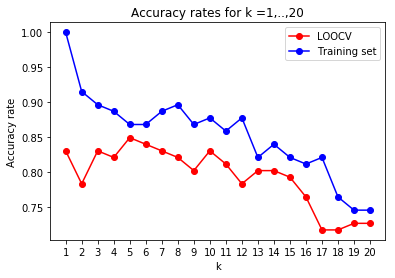

In [12]:
accuracy2 = []

# Calculating acuracy rates for k=1,..,20 using the whole data

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_set,y_set)
    p = knn.predict(X_set)       
    accuracy2.append(accuracy_score(p, y_set))

# Plotting accuracy rates for both LOOCV method and Training set method

plt.plot(list(range(1,21)),accuracy, marker = 'o', color = 'r', label = 'LOOCV')
plt.plot(list(range(1,21)),accuracy2, marker = 'o', color ='b', label = 'Training set')

plt.xticks(list(range(1,21)))
plt.title('Accuracy rates for k =1,..,20')
plt.xlabel('k')
plt.ylabel('Accuracy rate')
plt.legend()

plt.show()

The highest accuracy rate when using training set to both fit and predict is 1 when k=1 where as for LOOCV method it's below 0.85. For both methods the accuracy rate have a decreasing trend but it's more severe for the training set method. When using training set to fit and predict, it gives too optimistic accuracy rate due to fact that all the observations were used to fit the model and the same observations are used to predict and calculate the accuracy. This can be seen in the figure above where the accuracy rate for training set method is above LOOCV's all the time. The overfitted model performs well with the present data but it's prediction accuracy is poor. Usually we're interested in predicting the future values and thus training set accuracy/error is not to be used to determine the final model and validation accuracy/error should be used intead.